In [44]:
import subprocess as sp
print(sp.getoutput('which python3'))

# !python3 -m virtualenv IMAGE-REC
# !source IMAGE-REC/bin/activate

/opt/homebrew/bin/python3


In [45]:
%pip list
%pip install -r requirements.txt


Package                                           Version
------------------------------------------------- ------------
absl-py                                           1.2.0
aiml                                              0.9.2
aiohttp                                           3.8.1
aiosignal                                         1.2.0
appnope                                           0.1.3
argon2-cffi                                       21.3.0
argon2-cffi-bindings                              21.2.0
asgiref                                           3.5.2
astroid                                           2.9.3
asttokens                                         2.0.5
astunparse                                        1.6.3
async-timeout                                     4.0.2
attrs                                             21.4.0
autopep8                                          1.6.0
backcall                                          0.2.0
beautifulsoup4                      

In [46]:
import os
import cv2 as cv
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from imutils import contours

In [47]:
# from PIL import Image
# import glob
# import os

# # new folder path (may need to alter for Windows OS)
# # change path to your path
# path = '/Users/tareklein/Downloads/archive/train/plus cleaned' #the path where to save resized images
# # create new folder
# if not os.path.exists(path):
#     os.makedirs(path)

# # loop over existing images and resize
# # change path to your path
# for filename in glob.glob(path + '/*.jpg'): #path of raw images
#     img = Image.open(filename).resize((28,28))
#     # save resized images to new folder with existing filename
#     img.save('{}{}{}'.format(path,'/',os.path.split(filename)[1]))

In [48]:
def normalize_img(image, label):
    return (tf.cast(image, tf.float32) / 255.0, label)

In [49]:

mnist_corrupted = 'mnist_corrupted'
mnist = 'mnist'

dataset = mnist_corrupted

(train_dataset, test_dataset), ds_info = tfds.load(
    dataset,
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
    )

# (train_dataset2, test_dataset2), ds_info = tfds.load(
#     mnist_corrupted,
#     split=['train', 'test'],
#     shuffle_files=True,
#     as_supervised=True,
#     with_info=True
#     )

In [50]:
train_dataset = train_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
# Store dataset in cache
train_dataset = train_dataset.cache()
# Shuffle data
train_dataset = train_dataset.shuffle(len(train_dataset))
# Split up into a batch of 64
train_dataset = train_dataset.batch(64)
# Grab other stuff before it done dealing with current stuff
# Optimization 
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)


In [51]:
#test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
# Split up into a batch of 64
test_dataset = test_dataset.batch(64)
# Store dataset in cache
test_dataset = test_dataset.cache()
# Grab other stuff before it done dealing with current stuff
# Optimization 
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [52]:
# Visualise image tensor 0 to 9
visualise = False
if visualise:
    from tensorflow.keras.datasets import mnist
    x = 0
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(len(train_dataset))
    #train_dataset = train_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
    
    for (img, label) in train_dataset:
        if label.numpy() == x:
            print(img.numpy(), label.numpy())
            x+=1
            print('')
            print('---'*30)
            print('')
        if x == 10:
            break
    else:
        pass

In [53]:
train = True
if train:
    model = tf.keras.models.Sequential([
        tf.keras.Input((28,28,1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

    history = model.fit(train_dataset, epochs=30, validation_data=(train_dataset))


    model.save('handwritten.model')
else:
    pass
#model.summary()

Epoch 1/30
938/938 [==============================] - 3s 1ms/step - loss: 0.2678 - accuracy: 0.9215 - val_loss: 0.1279 - val_accuracy: 0.9619
Epoch 2/30
938/938 [==============================] - 1s 1ms/step - loss: 0.1097 - accuracy: 0.9669 - val_loss: 0.0839 - val_accuracy: 0.9747
Epoch 3/30
938/938 [==============================] - 1s 1ms/step - loss: 0.0759 - accuracy: 0.9769 - val_loss: 0.0490 - val_accuracy: 0.9854
Epoch 4/30
938/938 [==============================] - 1s 1ms/step - loss: 0.0570 - accuracy: 0.9821 - val_loss: 0.0465 - val_accuracy: 0.9852
Epoch 5/30
938/938 [==============================] - 1s 1ms/step - loss: 0.0447 - accuracy: 0.9854 - val_loss: 0.0322 - val_accuracy: 0.9896
Epoch 6/30
938/938 [==============================] - 1s 1ms/step - loss: 0.0359 - accuracy: 0.9884 - val_loss: 0.0289 - val_accuracy: 0.9905
Epoch 7/30
938/938 [==============================] - 1s 1ms/step - loss: 0.0282 - accuracy: 0.9909 - val_loss: 0.0162 - val_accuracy: 0.9952
Epoch 

: 

: 

In [ ]:
model = tf.keras.models.load_model('handwritten.model')

loss, accuracy = model.evaluate(train_dataset)

print(loss)
print(accuracy)

938/938 [==============================] - 1s 483us/step - loss: 0.0046 - accuracy: 0.9984
0.0045681544579565525
0.998449981212616


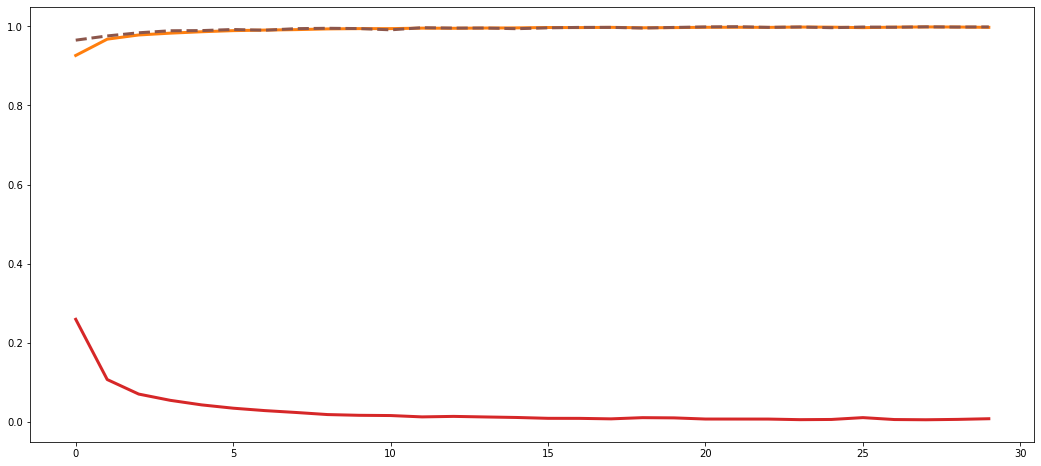

In [ ]:
plot = True
if plot:
    from matplotlib.lines import lineStyles
    import matplotlib.pyplot as plt
    plt.figure(figsize=(18,8))
    plt.plot(0,0, history.history['accuracy'], label='Accuracy', lw=3)
    plt.plot(0,0, history.history['loss'], label='Loss', lw=3)
    plt.plot(0,0, history.history['val_accuracy'], label='Val accuracy', lw=3, linestyle='--')
    plt.legend


In [ ]:
def rescaleFrame(frame, scale):
    width = int(frame.shape[1] * scale)
    height = int(frame.shape[1] * scale)
    print(width, height)
    dimensions = (width, height)
    
    return cv.resize(frame, dimensions, interpolation=cv.INTER_AREA)

In [ ]:
def zoom_at(img, zoom=1, angle=0, coord=None):
    
    cy, cx = [ i/2 for i in img.shape[:-1] ] if coord is None else coord[::-1]
    
    rot_mat = cv.getRotationMatrix2D((cx,cy), angle, zoom)
    result = cv.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv.INTER_LINEAR)
    
    return result

In [ ]:
def calculate_zoom(window_name, height):
    
    _, _, _, thresh_window_h = cv.getWindowImageRect(window_name)
    ratio = (thresh_window_h-height)/125
    if ratio < 1:
        ratio = 1
    return ratio

In [ ]:
def convert_28(name, copy_from, gray_range):
    _, window = cv.threshold(copy_from, gray_range[0], gray_range[1], cv.THRESH_BINARY)
    window = cv.resize(name, (28,28), interpolation=cv.INTER_AREA)
    window = window.astype("float32") / 255.0
    window = np.expand_dims(window, axis=-1)
    return window

In [ ]:
def predict(window):
    prediction = model.predict(window.reshape(1,28,28))
    predargmax = np.argmax(prediction)
    return predargmax

In [ ]:
def contour_x(contours):
    cent_moment = cv.moments(contours)
    try:
        answer = (int(cent_moment['m10']/cent_moment['m00']))
        return answer
    except ZeroDivisionError:
        pass

In [ ]:
def create_window(thresh, idx, cnt):
        x,y,w,h = cv.boundingRect(cnt)
        centercoords = [round(x+(w/2)), round(y+(h/2))]
        gray_range = (150, 255)
        fill_color = (0,0,0)
        window_name = 'Win_Number: ' + str(idx)
        _, _, window_w, window_h = cv.getWindowImageRect('Black & White (gray threshold)')
    
        # Filter out bounding boxed with a low height
        if (h) > 150:
            # Zoom onto number
            zoom_ratio = calculate_zoom('Black & White (gray threshold)', h)
            
            # Create window
            _, temp_window = cv.threshold(thresh, gray_range[0], gray_range[1], cv.THRESH_BINARY)
            
            border = 5
            # Top
            cv.rectangle(temp_window, (0, y-border), (window_w, 0), fill_color, -1)
            # Bottom
            cv.rectangle(temp_window, (0, y+h), (window_w, window_h), fill_color, -1)
            # Left
            cv.rectangle(temp_window, (x-border, 0), (0, window_h), fill_color, -1)
            # Right
            cv.rectangle(temp_window, (x+w+border, 0), (window_w, window_h), fill_color, -1)
            temp_window = zoom_at(temp_window, zoom_ratio, 0, centercoords)
            #cv.circle(temp_window, centercoords, 10, (255,255,255), 2)

            #cv.putText(temp_window, 'Ratio: ' + str(zoom_ratio), (20,80), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,0), 2)
            
            # Convert window to 28x28 for prediction (data trained on 28x28)
            temp_28 = convert_28(temp_window, thresh, gray_range)
            # Predict
            predargmax = predict(temp_28)
            # Bounding Box
            cv.rectangle(thresh, (x,y), (x+w, y+h), (255, 255, 0), 4)
            
            cv.putText(temp_window, 'Prediction: ' + str(predargmax), (20,40), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
            cv.putText(temp_window, 'Prediction: ' + str(predargmax), (20,40), cv.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 1)
            
            cv.imshow(window_name, temp_window)
            cv.moveWindow(window_name, cv.getWindowImageRect('Gray scale')[2]*(idx), cv.getWindowImageRect('Gray scale')[3])
            
            return predargmax

In [ ]:
capture = cv.VideoCapture(0)
scale = 0.35
gray_range = (250, 255)
predictions = []
cleared = True
while True:
    isTrue, frame = capture.read()
    frame_resized = rescaleFrame(frame, scale)

    # Grayscaled
    gray = cv.cvtColor(frame_resized, cv.COLOR_BGR2GRAY)
    gray_28 = convert_28(gray, gray, gray_range)
    predargmax_gray_28 = predict(gray_28)

    # Black and white
    ret, thresh = cv.threshold(gray, gray_range[0], gray_range[1], cv.THRESH_BINARY)
    thresh_28 = convert_28(thresh, thresh, gray_range)
    predargmax_thresh_28 = predict(thresh_28)
      
      
    _, result = cv.threshold(gray, gray_range[0], gray_range[1], cv.THRESH_BINARY)
    cv.rectangle(result, (0, 0), (500,500), (255,255,255), -1)
    
      

    cv.putText(gray, 'Gray: ' + str(predargmax_gray_28), (20,40), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv.putText(gray, 'Gray: ' + str(predargmax_gray_28), (20,40), cv.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 1)
    cv.putText(gray, 'B&W: ' + str(predargmax_thresh_28), (20,80), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv.putText(gray, 'B&W: ' + str(predargmax_thresh_28), (20,80), cv.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 1)
           
    cv.imshow('Gray scale', gray)
    
    cv.imshow('Black & White (gray threshold)', thresh)
    cv.moveWindow('Black & White (gray threshold)', cv.getWindowImageRect('Gray scale')[2], 0)
    
    
    number_contours, _ = cv.findContours(cv.morphologyEx(thresh, cv.MORPH_OPEN, np.ones((2,2))), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        
    if len(number_contours) > 0:
        try:
            sorted_contours = sorted(number_contours, key = contour_x, reverse = False)
        except TypeError:
            pass
        for idx, cnt in enumerate(sorted_contours):
            answer = create_window(thresh, idx, cnt)
            if answer is not None:
                predictions.append(answer)
            cleared = False
        for x in range(len(predictions)):
            placement = 50
            space = 50
            cv.putText(result, str(predictions[x]), (placement+(space*x),200), cv.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 5)
            if x < len(predictions)-1:
                cv.putText(result, '+', (round(placement+(space*x)+(space/2)),200), cv.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 3)
            if x == len(predictions)-1:
                cv.putText(result, '=', (round(placement+(space*x)+(space/2)),200), cv.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 3)
                cv.putText(result, str(sum(predictions)), (placement+(space*(x+1)),200), cv.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 5)
        predictions = []
    else:
        if not cleared:
            for x in range(100):
                window_name = 'Win_Number: ' + str(x)
                cv.destroyWindow(window_name)
            cleared = True
            
    cv.imshow('Maffs', result)
    cv.moveWindow('Maffs', cv.getWindowImageRect('Gray scale')[2]*2, 0)

    if cv.waitKey(20) & 0xFF==ord('q'):
        break
    
capture.release()
cv.waitKey(100)
cv.destroyAllWindows()
sp.getoutput('deactivate')
cv.waitKey(100)

448 448
1/1 [==============================] - 0s 9ms/step
448 448
1/1 [==============================] - 0s 8ms/step
448 448
1/1 [==============================] - 0s 8ms/step
448 448
1/1 [==============================] - 0s 8ms/step
448 448
1/1 [==============================] - 0s 7ms/step
448 448
1/1 [==============================] - 0s 7ms/step
448 448
1/1 [==============================] - 0s 8ms/step
448 448
1/1 [==============================] - 0s 8ms/step
448 448
1/1 [==============================] - 0s 8ms/step
448 448
1/1 [==============================] - 0s 7ms/step
448 448
1/1 [==============================] - 0s 7ms/step
448 448
1/1 [==============================] - 0s 8ms/step
448 448
1/1 [==============================] - 0s 8ms/step
448 448
1/1 [==============================] - 0s 8ms/step
448 448
1/1 [==============================] - 0s 8ms/step
448 448
1/1 [==============================] - 0s 8ms/step
448 448
1/1 [==============================] - 0s 8ms/st

-1